## Entrenamiento PM2.5

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

## Hacemos una función para graficar

In [3]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('XGBoost Predicted vs Actual')
    plt.show()

In [4]:
def ploter_title(y_test_0,X_test_0,pronosticados_0,model,titulo,ejex,ejey,color_user,ruta="./savedpic.png",dpi_user=300):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color=color_user)
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.title(titulo)
    plt.savefig(ruta, dpi=dpi_user)
    plt.show()

## Cargamos los modelos ya entrenados:

In [5]:
conta = 'PM25'

In [6]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [7]:
data_hour_merge = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/"+
                              "DanielBustillos/contaminación/pipeline-norberto/datos/datos_modelos_PM25mean.csv")

In [8]:
data_hour_merge.head(2)

,PM25mean_14.0_max,PM10mean_0.0_mean,PM10mean_20.0_mean,PM10_8.0_mean,PM10mean_3.0_max,PM2.5_6.0_max,O3_max,PM10mean_18.0_mean,fecha,PM25mean_2.0_max,...,PM25mean_max_frcst_14,PM25mean_max_frcst_15,PM25mean_max_frcst_16,PM25mean_max_frcst_17,PM25mean_max_frcst_18,PM25mean_max_frcst_19,PM25mean_max_frcst_20,PM25mean_max_frcst_21,PM25mean_max_frcst_22,PM25mean_max_frcst_23
0,14.750,21.216667,21.350,17.6,29.583333,17.0,21.0,20.991667,2019-07-29 09:00:00,18.125000,...,18.958333,19.166667,19.291667,19.333333,19.208333,19.416667,19.541667,19.916667,19.916667,20.083333
1,14.625,20.666667,21.475,16.6,29.125000,16.0,16.0,21.266667,2019-07-29 08:00:00,17.416667,...,19.125000,18.958333,19.166667,19.291667,19.333333,19.208333,19.416667,19.541667,19.916667,19.916667


Definimos la lista de los targets:

In [9]:
target = "PM25mean_max_frcst_"

In [10]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [11]:
data_hour_merge[["fecha",'PM25mean_0.0_max','PM25mean_1.0_max','PM25mean_2.0_max']].head(10)

,fecha,PM25mean_0.0_max,PM25mean_1.0_max,PM25mean_2.0_max
0,2019-07-29 09:00:00,19.166667,19.166667,18.125000
1,2019-07-29 08:00:00,19.166667,18.125000,17.416667
2,2019-07-29 07:00:00,18.125000,17.416667,16.916667
3,2019-07-29 06:00:00,17.416667,16.916667,16.625000
4,2019-07-29 05:00:00,16.916667,16.625000,16.500000
5,2019-07-29 04:00:00,16.625000,16.500000,16.750000
6,2019-07-29 03:00:00,16.500000,16.750000,16.625000
7,2019-07-29 02:00:00,16.750000,16.625000,16.541667
8,2019-07-29 01:00:00,16.625000,16.541667,16.416667
9,2019-07-29 00:00:00,16.541667,16.416667,16.000000


In [12]:
data_hour_merge[["fecha","PM25mean_0.0_max","PM25mean_max_frcst_1","PM25mean_max_frcst_2","PM25mean_max_frcst_3"]].head(10)

,fecha,PM25mean_0.0_max,PM25mean_max_frcst_1,PM25mean_max_frcst_2,PM25mean_max_frcst_3
0,2019-07-29 09:00:00,19.166667,19.333333,19.916667,19.958333
1,2019-07-29 08:00:00,19.166667,19.166667,19.333333,19.916667
2,2019-07-29 07:00:00,18.125000,19.166667,19.166667,19.333333
3,2019-07-29 06:00:00,17.416667,18.125000,19.166667,19.166667
4,2019-07-29 05:00:00,16.916667,17.416667,18.125000,19.166667
5,2019-07-29 04:00:00,16.625000,16.916667,17.416667,18.125000
6,2019-07-29 03:00:00,16.500000,16.625000,16.916667,17.416667
7,2019-07-29 02:00:00,16.750000,16.500000,16.625000,16.916667
8,2019-07-29 01:00:00,16.625000,16.750000,16.500000,16.625000
9,2019-07-29 00:00:00,16.541667,16.625000,16.750000,16.500000


In [13]:
data_hour_merge.drop("fecha",axis=1,inplace=True)

In [14]:
data_hour_merge.shape

(30298, 155)

# Empezamos con el entrenamiento:

#### HORA 1 

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [15]:
hora = 1

In [16]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [17]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [18]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

Definimos los conjuntos de prueba:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [20]:
X_train.columns.tolist()

['PM25mean_14.0_max',
 'PM10mean_0.0_mean',
 'PM10mean_20.0_mean',
 'PM10_8.0_mean',
 'PM10mean_3.0_max',
 'PM2.5_6.0_max',
 'O3_max',
 'PM10mean_18.0_mean',
 'PM25mean_2.0_max',
 'PM2.5_9.0_mean',
 'PM10_1.0_mean',
 'PM2.5_2.0_max',
 'PM25mean_0.0_min',
 'PM25mean_13.0_max',
 'PM10mean_10.0_max',
 'PM25mean_5.0_max',
 'PM10mean_15.0_max',
 'PM10mean_6.0_max',
 'PM10mean_0.0_min',
 'NO2_3.0_max',
 'PM10mean_max',
 'PM10_1.0_max',
 'PM10mean_1.0_max',
 'PM10_10.0_mean',
 'PM2.5_4.0_mean',
 'PM10mean_7.0_mean',
 'PM10mean_21.0_mean',
 'PM2.5_mean',
 'PM10mean_23.0_mean',
 'PM25mean_0.0_mean',
 'PM10_4.0_max',
 'PM10mean_17.0_max',
 'PM10_12.0_mean',
 'PM25mean_6.0_max',
 'PM25mean_6.0_mean',
 'PM25mean_1.0_max',
 'PM10mean_6.0_mean',
 'PM10mean_11.0_mean',
 'PM2.5_3.0_max',
 'PM2.5_2.0_mean',
 'PM10mean_22.0_mean',
 'PM10mean_16.0_mean',
 'PM10mean_8.0_mean',
 'PM25mean_11.0_mean',
 'PM25mean_4.0_max',
 'PM25mean_0.0_max',
 'NO2_max',
 'WSP_mean',
 'PM10mean_9.0_mean',
 'PM10mean_17.0_me

## Modelo

In [21]:
from xgboost.sklearn import XGBRegressor

In [22]:
model[0] = XGBRegressor(learning_rate=0.05,n_estimators=1500,n_jobs=128,random_state=123)

In [23]:
model[0].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=128, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [24]:
#Predict 
pronos_1 = model[0].predict(X_test)

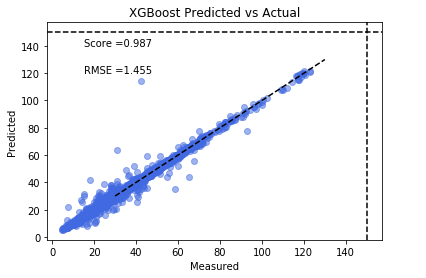

In [25]:
ploter(y_test,X_test,pronos_1,model[0])

In [26]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/PM25/PM25_1hora.pkl']

## Gradienst Descent:

# HORA 2

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [27]:
hora = 2

In [28]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [29]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [30]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [32]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=1500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [33]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [34]:
pronos_2_q = model[hora-1].predict(X_test)

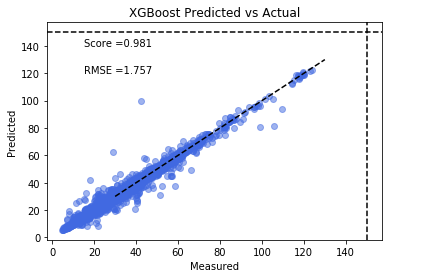

In [35]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [36]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/PM25/PM25_2hora.pkl']

# HORA 3

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [37]:
hora = 3

In [38]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [39]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [40]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [42]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=1500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [43]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [44]:
pronos_2_q = model[hora-1].predict(X_test)

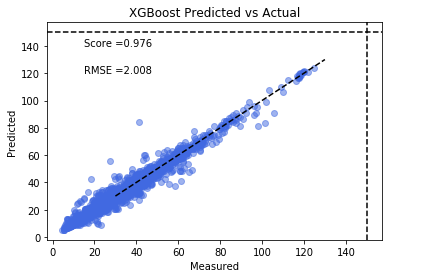

In [45]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [46]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+ conta +'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_3hora.pkl']

# HORA 4

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [47]:
hora = 4

In [48]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [49]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [50]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [52]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=1500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [53]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [54]:
pronos_2_q = model[hora-1].predict(X_test)

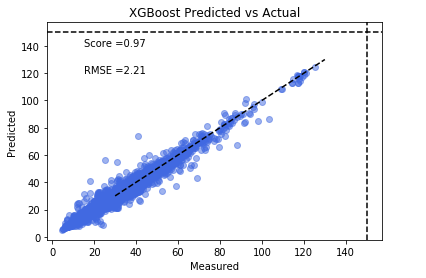

In [55]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [56]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_4hora.pkl']

# HORA 5

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [57]:
hora = 5

In [58]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [59]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [60]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [62]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [63]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:56:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [64]:
pronos_2_q = model[hora-1].predict(X_test)

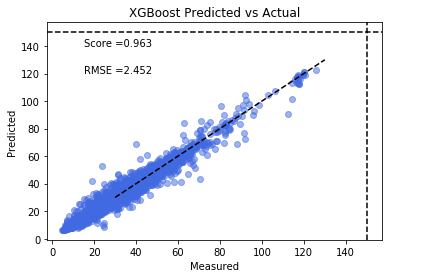

In [65]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [66]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_5hora.pkl']

# HORA 6

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [67]:
hora = 6

In [68]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [69]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [70]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [72]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [73]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [74]:
pronos_2_q = model[hora-1].predict(X_test)

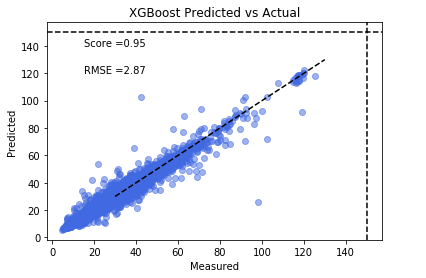

In [75]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [76]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_6hora.pkl']

# HORA 7

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [77]:
hora = 7

In [78]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [79]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [80]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [82]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [83]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [84]:
pronos_2_q = model[hora-1].predict(X_test)

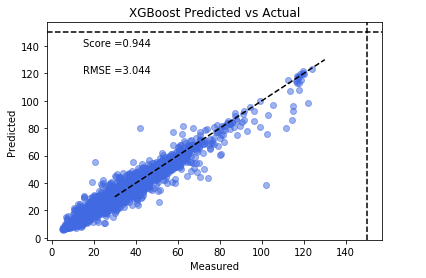

In [85]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [86]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_7hora.pkl']

# HORA 8

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [87]:
hora = 8

In [88]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [89]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [90]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [92]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [93]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [94]:
pronos_2_q = model[hora-1].predict(X_test)

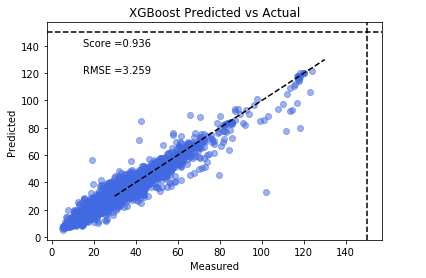

In [95]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [96]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_8hora.pkl']

# HORA 9

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [97]:
hora = 9

In [98]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [99]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [100]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [102]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [103]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [104]:
pronos_2_q = model[hora-1].predict(X_test)

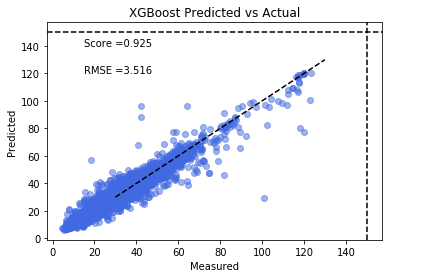

In [105]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [106]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_9hora.pkl']

# HORA 10

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [107]:
hora = 10

In [108]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [109]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [110]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [112]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [113]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [114]:
pronos_2_q = model[hora-1].predict(X_test)

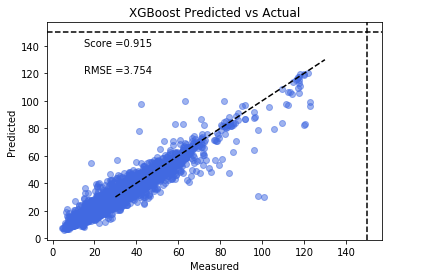

In [115]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [116]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_10hora.pkl']

# HORA 11

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [117]:
hora = 11

In [118]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [119]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [120]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [122]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [123]:
1*1

1

In [124]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [125]:
pronos_2_q = model[hora-1].predict(X_test)

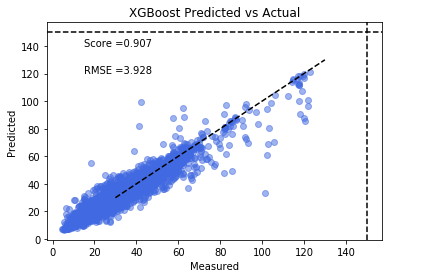

In [126]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [127]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_11hora.pkl']

# HORA 12

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [128]:
hora = 12

In [129]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [130]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [131]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [133]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [134]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [135]:
pronos_2_q = model[hora-1].predict(X_test)

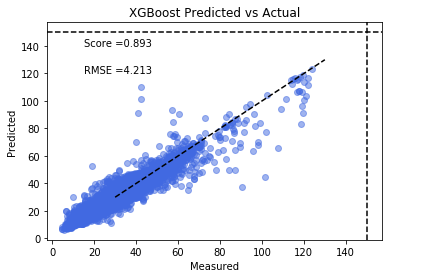

In [136]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [137]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_12hora.pkl']

# HORA 13

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [138]:
hora = 13

In [139]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [140]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [141]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [143]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [144]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [145]:
pronos_2_q = model[hora-1].predict(X_test)

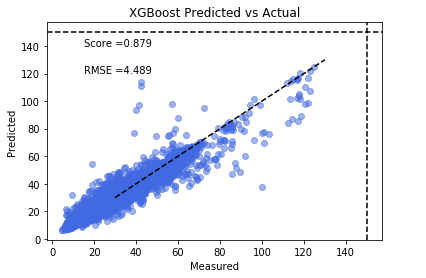

In [146]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [147]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_13hora.pkl']

# HORA 14

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [148]:
hora = 14

In [149]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [150]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [151]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [153]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [154]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [155]:
pronos_2_q = model[hora-1].predict(X_test)

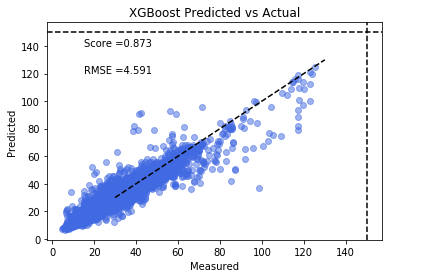

In [156]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [157]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/PM25/PM25_14hora.pkl']

# HORA 15

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [158]:
hora = 15

In [159]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [160]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [161]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [163]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [164]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:54:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [165]:
pronos_2_q = model[hora-1].predict(X_test)

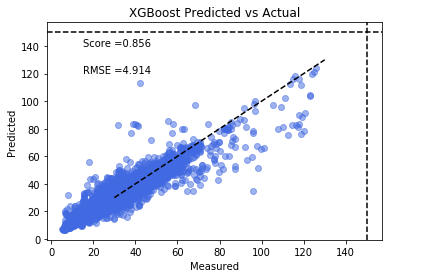

In [166]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [167]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/PM25/PM25_15hora.pkl']

# HORA 16

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [168]:
hora = 16

In [169]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [170]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [171]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [173]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [174]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [175]:
pronos_2_q = model[hora-1].predict(X_test)

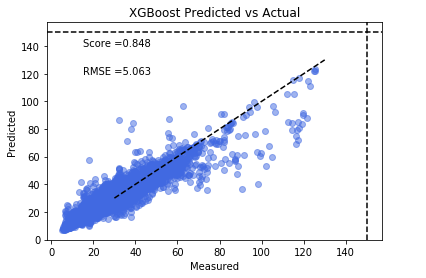

In [176]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [177]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_16hora.pkl']

# HORA 17

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [178]:
hora = 17

In [179]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [180]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [181]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [183]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [184]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:10:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [185]:
pronos_2_q = model[hora-1].predict(X_test)

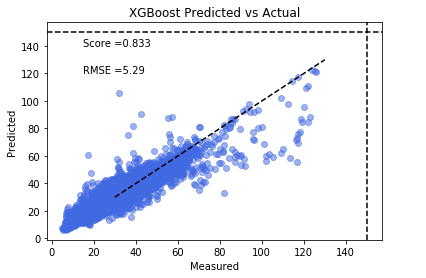

In [186]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [187]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_17hora.pkl']

# HORA 18

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [188]:
hora = 18

In [189]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [190]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [191]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [193]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [194]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:16:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [195]:
pronos_2_q = model[hora-1].predict(X_test)

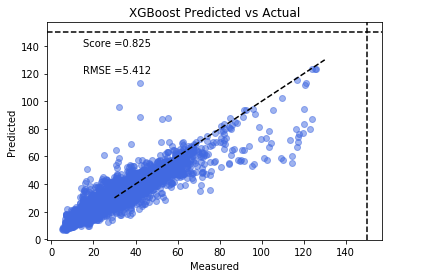

In [196]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [197]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+ conta+'_'+ str(hora) + 'hora.pkl') 

['./modelos/PM25/PM25_18hora.pkl']

# HORA 19

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [198]:
 hora = 19

In [199]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [200]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [201]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [203]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [204]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [205]:
pronos_2_q = model[hora-1].predict(X_test)

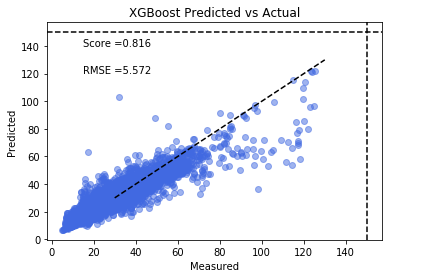

In [206]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [207]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_19hora.pkl']

In [208]:
1*1

1

# HORA 20

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [209]:
hora = 20

In [210]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [211]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [212]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [214]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [215]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [216]:
pronos_2_q = model[hora-1].predict(X_test)

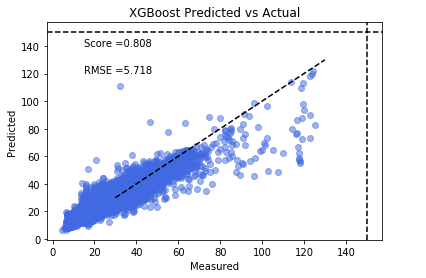

In [217]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [218]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_20hora.pkl']

# HORA 21

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [219]:
hora = 21

In [220]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [221]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [222]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [224]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [225]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [226]:
pronos_2_q = model[hora-1].predict(X_test)

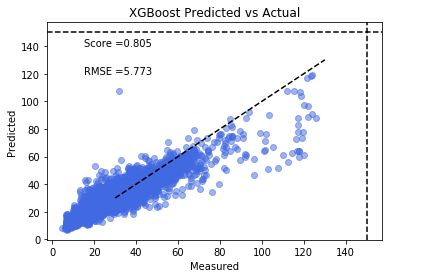

In [227]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [228]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/PM25/PM25_21hora.pkl']

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [229]:
hora = 22

In [230]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [231]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [232]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [234]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [235]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [236]:
pronos_2_q = model[hora-1].predict(X_test)

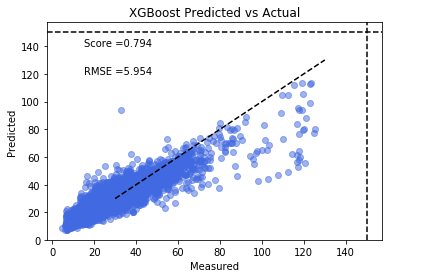

In [237]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [238]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_22hora.pkl']

# HORA 23

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [239]:
hora = 23

In [240]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [241]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [242]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [244]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)

In [245]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [246]:
pronos_2_q = model[hora-1].predict(X_test)

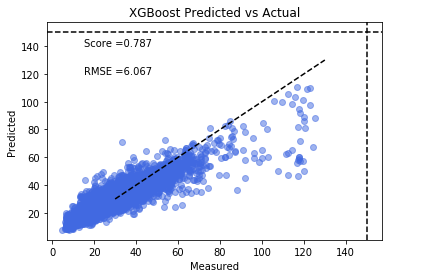

In [247]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [248]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_23hora.pkl']

# HORA 24

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [249]:
hora = 24

In [250]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [251]:
str(target+str(hora))

'PM25mean_max_frcst_24'

In [252]:
dataset = dataset[dataset["PM25mean_max_frcst_24"]>70]

In [253]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [254]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [256]:
alg = model[hora-1]

In [257]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,n_jobs=100,random_state=123,max_depth=5,
                            gamma = 0.,colsample_bytree = 1,scale_pos_weight =1)

In [258]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=64,random_state=123,max_depth=10, gamma=1.16)#primer intento

In [259]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:53:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=64, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

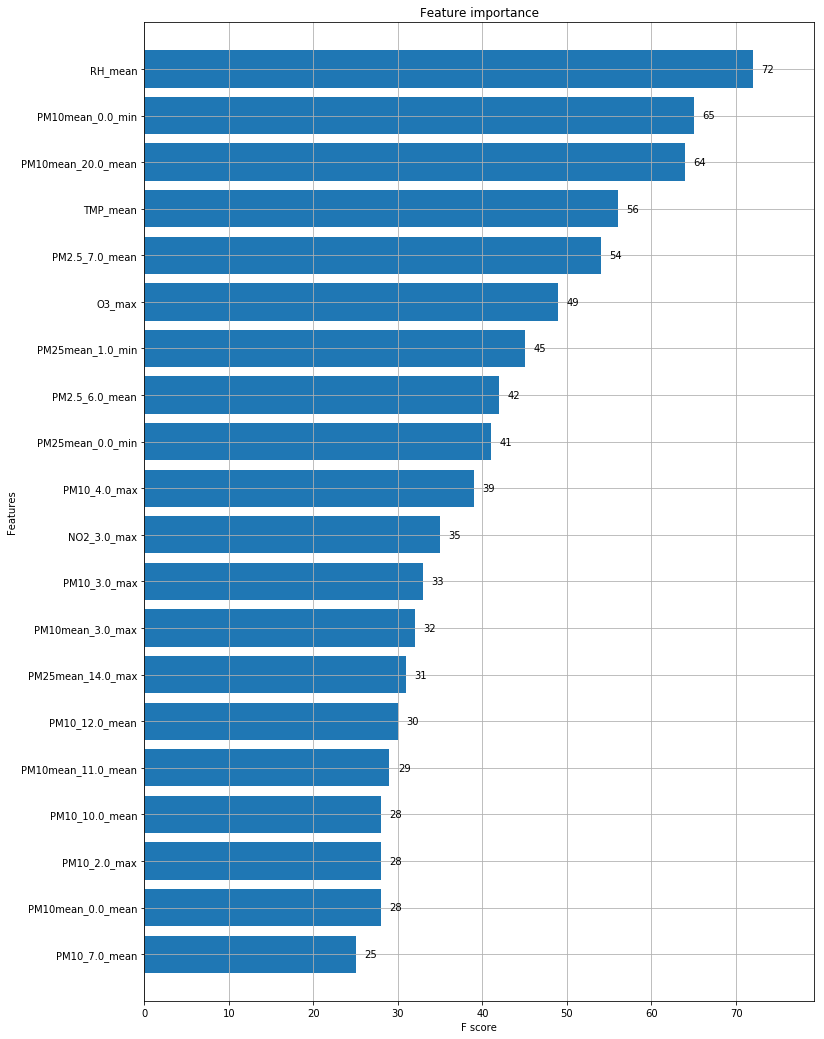

In [260]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model[hora-1], max_num_features=20, height=0.8, ax=ax)
plt.show()

In [261]:
pronos_2_q = model[hora-1].predict(X_test)

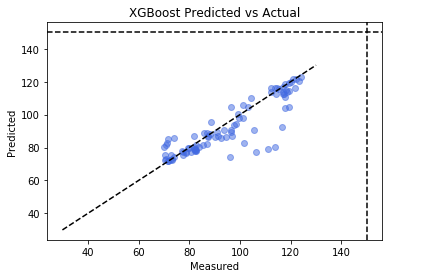

In [262]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

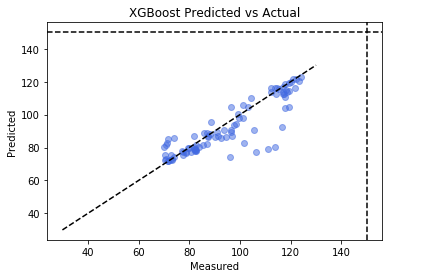

In [263]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

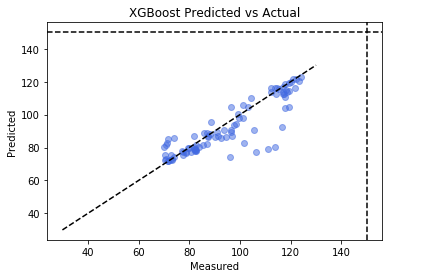

In [264]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

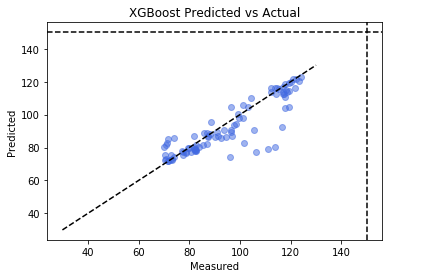

In [265]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

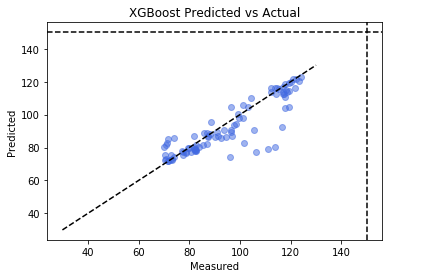

In [266]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

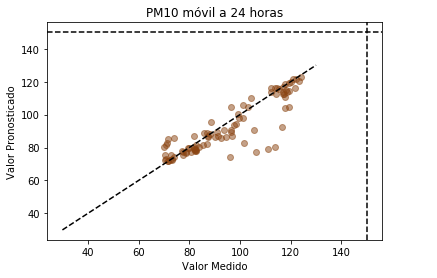

In [267]:
ploter_title(y_test,X_test,pronos_2_q,model[hora-1],"PM10 móvil a 24 horas","Valor Medido","Valor Pronosticado","saddlebrown")

In [268]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/PM25/PM25_24hora.pkl']

# Viz

## O3

In [ ]:
conta = "O3"
model_O3_24 = joblib.load(str('./modelos/'+ conta +'/'+ conta + '_'+str(24)+'hora.pkl'))

data_hour_merge_O3 = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline-norberto/datos_modelos_O3.csv")

data_hour_merge_O3.head(2)

target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

hora = 24

dataset = data_hour_merge_O3.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

#Definimos los conjuntos de prueba:

X_train_O3, X_test_O3, y_train_O3, y_test_O3 = train_test_split(X, y, test_size=0.3, random_state=123)

#Predict 
pronos_1 = model_O3_24.predict(X_test_O3)

In [ ]:
plt.scatter(pronos_2_q, y_test,alpha=0.4,color="saddlebrown",label = "PM10")
plt.scatter(pronos_1, y_test_O3,alpha=0.1,color="royalblue",label="O3")

#score = round(model.score(X_test_0, y_test_0),3)
#rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
plt.plot([30,130],[30,130],color="k",linestyle='--')

plt.axhline(y=150, color='k', linestyle='--')
plt.axvline(x=150, color='k', linestyle='--')
plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
              horizontalalignment='right')
plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
              horizontalalignment='right')
plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
              horizontalalignment='right')
plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
              horizontalalignment='right')
#plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
              #horizontalalignment='left')
#plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
              #horizontalalignment='left')


plt.xlabel('Valor Medido')
plt.ylabel('Valor Pronosticado')
plt.title('Valores Medidos vs Pronosticados')

plt.show()

In [ ]:
import random

In [ ]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=280, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.tail(60).head(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.tail(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])
plt.plot([90,190],[90,190],color="k",alpha=0.9)
plt.scatter(pronos_2_q, y_test,alpha=0.8,color="saddlebrown",label = "PM10")
plt.scatter(pronos_1, y_test_O3,alpha=0.7,color="royalblue",label="O3")


plt.xlabel('Valor Medido')
plt.ylabel('Valor Pronosticado')
plt.title('Valores Medidos vs Pronosticados')

plt.axhline(y=150, color='k', linestyle='--',alpha=0.6)
plt.axvline(x=150, color='k', linestyle='--',alpha=0.6)


# And a corresponding grid
#ax.grid(which='both')

# Or if you want different settings for the grids:
# ax.grid(which='minor', alpha=0.01)
# ax.grid(which='major', alpha=0.3)

ax.set_xlim(80,200)
ax.set_ylim(80,200)

plt.legend()
plt.show()